# Loading the necessary libraries

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional 
import pandas as pd

In [25]:
set_seed(455) #sets the integer starting value used in generating random numbers
np.random.seed(455)

# Loading the dataset

In [28]:
data = pd.read_csv('D:\\SLIIT\\3rd year 2nd sem\\Machine Learning amd Optimization Methods\\Coding\\Mastercard_stock_history.csv',index_col='Date',parse_dates=['Date']).drop(['Dividends','Stock Splits'],axis=1)
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000
2006-06-02,4.511782,4.530387,4.352707,4.371312,37253000
2006-06-05,4.376895,4.581554,4.372244,4.572251,37188000
2006-06-06,4.649463,4.709930,4.446665,4.493178,49045000
2006-06-07,4.495968,4.502480,4.348986,4.428059,25013000


# Exploring the dataset

In [29]:
data.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-05-25 to 2021-10-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3872 non-null   float64
 1   High    3872 non-null   float64
 2   Low     3872 non-null   float64
 3   Close   3872 non-null   float64
 4   Volume  3872 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 181.5 KB


In [32]:
data.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [33]:
tstart = 2016
tend = 2020

In [34]:
def train_test_plot(dataset,tstart,tend):
    data.loc[f"{tstart}":f"{tend}","High"].plot(figsize=(16,4),legend=True)
    data.loc[f"{tend+1}":,"High"].plot(figsize=(16,4),legend=True)
    plt.legend([f"Train (Before {tend+1})",f"Test ({tend+1} and beyond)"])
    plt.title("MaterCard Stock Price")
    plt.show()

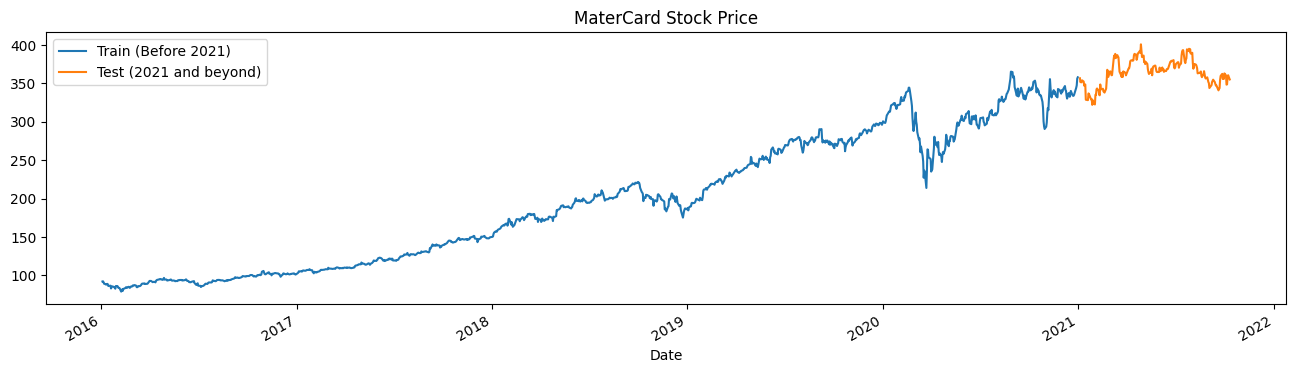

In [35]:
train_test_plot(data,tstart,tend)

# Data Preprocessing

In [37]:
def train_test_split(dataset,tstart,tend):
    train = data.loc[f"{tstart}":f"{tend}","High"].values
    test = data.loc[f"{tend+1}":,"High"].values
    return train, test

In [39]:
training_set, testing_set = train_test_split(data,tstart,tend)

* The MinMaxScaler is used to standardize the training set, which will help us to avoid anomalies or outliers. We can use **StandardScaler to increase our model performance.**

In [41]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)

* **We can also increase or reduce the number of steps(n_steps) to optimize the model performance.**

In [45]:
def split_sequence(sequence,n_steps):
    x,y = list(),list()
    
    for i in range(len(sequence)):
        end_ix = i + n_steps
        
        if end_ix > len(sequence) - 1:
            break
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x),np.array(y)

In [46]:
n_steps = 60
features = 1

In [47]:
#Splitting into samples
x_train,y_train = split_sequence(training_set_scaled,n_steps)

In [48]:
#Reshaping x_train for model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],features)

# LSTM Model

In [49]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125,activation='tanh',input_shape=(n_steps,features)))
model_lstm.add(Dense(units=1))

In [50]:
#Compiling the model
model_lstm.compile(optimizer='RMSProp',loss='mse')

In [51]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Training the model
model_lstm.fit(x_train,y_train,epochs=50,batch_size=32)

Train on 1199 samples
Epoch 1/50
1199/1199 [==============================] - 7s 6ms/sample - loss: 0.0161
Epoch 2/50
1199/1199 [==============================] - 4s 3ms/sample - loss: 0.0031
Epoch 3/50
1199/1199 [==============================] - 4s 3ms/sample - loss: 0.0021
Epoch 4/50
1199/1199 [==============================] - 4s 3ms/sample - loss: 0.0015
Epoch 5/50
1199/1199 [==============================] - 4s 3ms/sample - loss: 0.0014
Epoch 6/50
1199/1199 [==============================] - 4s 3ms/sample - loss: 0.0012
Epoch 7/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 9.3581e-04
Epoch 8/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 9.8555e-04
Epoch 9/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 8.7621e-04
Epoch 10/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 9.9842e-04
Epoch 11/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 7.5944e-04
Epoch 12/50
1199/1199

In [55]:
dataset_total = data.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(testing_set) - n_steps:].values
inputs = inputs.reshape(-1,1)

In [56]:
#Scaling
inputs = sc.transform(inputs)

In [57]:
#Split into samples
x_test,y_test = split_sequence(inputs,n_steps)

In [58]:
#Reshape
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],features)

In [59]:
#Prediction
predicted_stock_price = model_lstm.predict(x_test)

C:\Users\binur\anaconda3\envs\tfradeon\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [60]:
predicted_stock_price

array([[1.0170964 ],
       [1.0128837 ],
       [0.9936321 ],
       [1.000267  ],
       [0.99514693],
       [1.0071403 ],
       [0.99983853],
       [0.97999465],
       [0.98801553],
       [0.9850044 ],
       [0.9096792 ],
       [0.9151671 ],
       [0.9448346 ],
       [0.93853116],
       [0.93366385],
       [0.91305107],
       [0.91595936],
       [0.88644373],
       [0.91199756],
       [0.89684314],
       [0.89140797],
       [0.93865395],
       [0.93370676],
       [0.9632664 ],
       [0.96398497],
       [0.95413196],
       [0.93547046],
       [0.9348459 ],
       [0.98897547],
       [0.959921  ],
       [0.9686097 ],
       [0.9519881 ],
       [0.95193446],
       [0.94776213],
       [0.9678949 ],
       [1.0046107 ],
       [1.0571731 ],
       [1.0459034 ],
       [1.0175642 ],
       [1.0472417 ],
       [1.0434864 ],
       [1.042313  ],
       [1.0284357 ],
       [1.0309793 ],
       [1.1107899 ],
       [1.1185513 ],
       [1.1068388 ],
       [1.128

In [61]:
#Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[369.92316],
       [368.718  ],
       [363.2105 ],
       [365.10864],
       [363.64386],
       [367.07492],
       [364.98605],
       [359.30914],
       [361.60373],
       [360.74234],
       [339.19336],
       [340.76334],
       [349.25058],
       [347.4473 ],
       [346.05487],
       [340.15796],
       [340.99   ],
       [332.54617],
       [339.8566 ],
       [335.5212 ],
       [333.96634],
       [347.48242],
       [346.06714],
       [354.52353],
       [354.7291 ],
       [351.91037],
       [346.5717 ],
       [346.39304],
       [361.87836],
       [353.5665 ],
       [356.05212],
       [351.29706],
       [351.2817 ],
       [350.08807],
       [355.84766],
       [366.35126],
       [381.38828],
       [378.16428],
       [370.057  ],
       [378.54712],
       [377.47278],
       [377.13712],
       [373.1671 ],
       [373.89478],
       [396.72693],
       [398.94727],
       [395.5966 ],
       [401.86734],
       [394.04535],
       [400.17642],


In [62]:
def plot_predictions(test,predicted):
    plt.plot(test,color='gray',label='Real')
    plt.plot(predicted,color='red',label='Predicted')
    plt.title('Mastercard Stock Price Prediction')
    plt.xlabel("Time")
    plt.ylabel("Mastercard Stock Price")
    plt.legend()
    plt.show()

In [63]:
def return_rmse(test,predicted):
    rmse = np.sqrt(mean_squared_error(test,predicted))
    print('The root mean squared error is {:.2f}'.format(rmse))

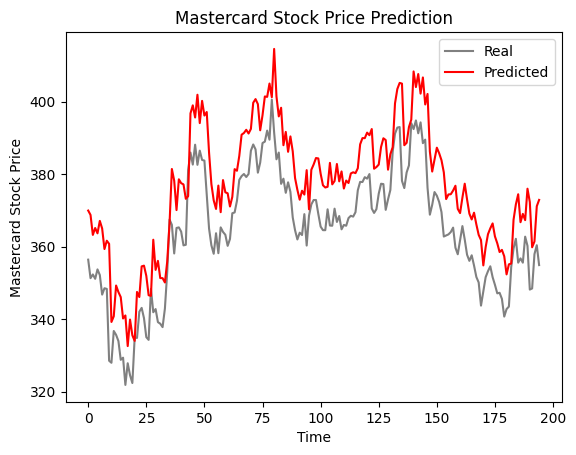

In [64]:
plot_predictions(testing_set,predicted_stock_price)

In [67]:
return_rmse(testing_set,predicted_stock_price)

The root mean squared error is 13.20


# GRU Model

* It is a type of Recurrent Neural Network(RNN) that in, certain cases, has advnatages over Long Short Term Memory(LSTM). GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

In [69]:
model_gru = Sequential()
model_gru.add(GRU(units=125,activation='tanh',input_shape=(n_steps,features)))
model_gru.add(Dense(units=1))

In [70]:
#Compiling the RNN model
model_gru.compile(optimizer='RMSProp',loss='mse')

In [71]:
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_2 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [72]:
model_gru.fit(x_train,y_train,epochs=50,batch_size=32)

Train on 1199 samples
Epoch 1/50
1199/1199 [==============================] - 6s 5ms/sample - loss: 0.0116
Epoch 2/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.0016
Epoch 3/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.0011
Epoch 4/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 9.2776e-04
Epoch 5/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 8.9742e-04
Epoch 6/50
1199/1199 [==============================] - 3s 2ms/sample - loss: 6.9762e-04
Epoch 7/50
1199/1199 [==============================] - 2s 2ms/sample - loss: 8.6895e-04
Epoch 8/50
1199/1199 [==============================] - 2s 2ms/sample - loss: 7.2816e-04
Epoch 9/50
1199/1199 [==============================] - 2s 2ms/sample - loss: 6.2681e-04
Epoch 10/50
1199/1199 [==============================] - 2s 2ms/sample - loss: 5.9334e-04
Epoch 11/50
1199/1199 [==============================] - 2s 2ms/sample - loss: 5.4291e-04
Epoch 12/

In [73]:
GRU_predicted_stock_price = model_gru.predict(x_test)
GRU_predicted_stock_price

C:\Users\binur\anaconda3\envs\tfradeon\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[0.93999684],
       [0.9365892 ],
       [0.9171199 ],
       [0.9248186 ],
       [0.91881615],
       [0.93094367],
       [0.9226379 ],
       [0.9041873 ],
       [0.913135  ],
       [0.91044927],
       [0.83658487],
       [0.846192  ],
       [0.87491643],
       [0.8683384 ],
       [0.8630876 ],
       [0.84285927],
       [0.8479773 ],
       [0.818114  ],
       [0.84596825],
       [0.8277697 ],
       [0.82426244],
       [0.8704023 ],
       [0.86281514],
       [0.89289194],
       [0.8905489 ],
       [0.8818552 ],
       [0.8628029 ],
       [0.8634103 ],
       [0.916385  ],
       [0.8841252 ],
       [0.8947423 ],
       [0.87660736],
       [0.8794754 ],
       [0.87443006],
       [0.8952755 ],
       [0.92984146],
       [0.9799563 ],
       [0.96656793],
       [0.93976766],
       [0.96954536],
       [0.9652114 ],
       [0.963979  ],
       [0.9491139 ],
       [0.95276934],
       [1.030264  ],
       [1.0360575 ],
       [1.0251358 ],
       [1.045

In [74]:
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
GRU_predicted_stock_price

array([[347.8666 ],
       [346.89172],
       [341.322  ],
       [343.5244 ],
       [341.80722],
       [345.27667],
       [342.90054],
       [337.62225],
       [340.18198],
       [339.41367],
       [318.2826 ],
       [321.031  ],
       [329.24847],
       [327.3666 ],
       [325.86447],
       [320.07758],
       [321.54172],
       [312.99844],
       [320.96698],
       [315.76074],
       [314.7574 ],
       [327.95703],
       [325.78653],
       [334.39087],
       [333.72055],
       [331.2335 ],
       [325.78302],
       [325.9568 ],
       [341.11172],
       [331.88287],
       [334.9202 ],
       [329.73218],
       [330.55267],
       [329.1093 ],
       [335.07275],
       [344.96133],
       [359.29816],
       [355.46802],
       [347.80103],
       [356.31982],
       [355.07996],
       [354.7274 ],
       [350.4748 ],
       [351.52054],
       [373.69016],
       [375.34753],
       [372.22305],
       [378.16342],
       [370.97134],
       [376.9999 ],


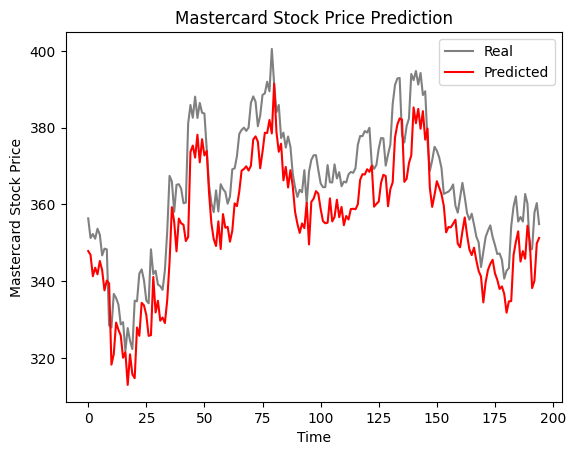

In [75]:
plot_predictions(testing_set,GRU_predicted_stock_price)